## Inspect NetCDF File Structure

This cell loads the dataset `CS2WFA_25km_202008.nc` to display its dimensions, coordinates, and data variables.

In [4]:
import xarray as xr
import os

# Define the data directory and file path
data_dir = r"D:\phd\data\Fons_2023_cs2fwa"
filename = "CS2WFA_25km_202008.nc"
filepath = os.path.join(data_dir, filename)

# Load the NetCDF dataset
ds = xr.open_dataset(filepath)

# Display dataset information
print("=" * 60)
print(f"Dataset: {filename}")
print("=" * 60)
print("\nDataset Overview:")
print(ds)
print("\n" + "=" * 60)
print("Dimensions:")
print("=" * 60)
for dim, size in ds.dims.items():
    print(f"  {dim}: {size}")

print("\n" + "=" * 60)
print("Coordinates:")
print("=" * 60)
for coord in ds.coords:
    print(f"  {coord}: {ds.coords[coord].dims}, dtype={ds.coords[coord].dtype}")

print("\n" + "=" * 60)
print("Data Variables:")
print("=" * 60)
for var in ds.data_vars:
    print(f"  {var}: {ds.data_vars[var].dims}, dtype={ds.data_vars[var].dtype}")
    if hasattr(ds[var], 'long_name'):
        print(f"    Long name: {ds[var].long_name}")
    if hasattr(ds[var], 'units'):
        print(f"    Units: {ds[var].units}")
    print()

# Close the dataset
ds.close()

Dataset: CS2WFA_25km_202008.nc

Dataset Overview:
<xarray.Dataset> Size: 5MB
Dimensions:                (time: 1, y: 332, x: 316)
Coordinates:
  * time                   (time) object 8B 2020-08-01 00:00:00
Dimensions without coordinates: y, x
Data variables:
    lat                    (y, x) float64 839kB ...
    lon                    (y, x) float64 839kB ...
    snow_freeboard         (time, y, x) float64 839kB ...
    ice_freeboard          (time, y, x) float64 839kB ...
    snow_depth             (time, y, x) float64 839kB ...
    sea_ice_concentration  (time, y, x) float64 839kB ...
Attributes:
    title:        Antarctic sea ice physical properties obtained from CryoSat...
    institution:  NASA GSFC Cryospheric Sciences Laboratory and University of...
    history:      File created on November 15, 2022, 13:43:24

Dimensions:
  time: 1
  y: 332
  x: 316

Coordinates:
  time: ('time',), dtype=object

Data Variables:
  lat: ('y', 'x'), dtype=float64
    Long name: latitude
    Uni

C:\Users\xliu38\AppData\Local\Temp\ipykernel_25500\2882007701.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for dim, size in ds.dims.items():


## Visualise Sea Ice Physical Properties

This cell creates a publication-quality figure showing the spatial distribution of sea-ice freeboard, total freeboard, and snow thickness across the Antarctic region for August 2020.

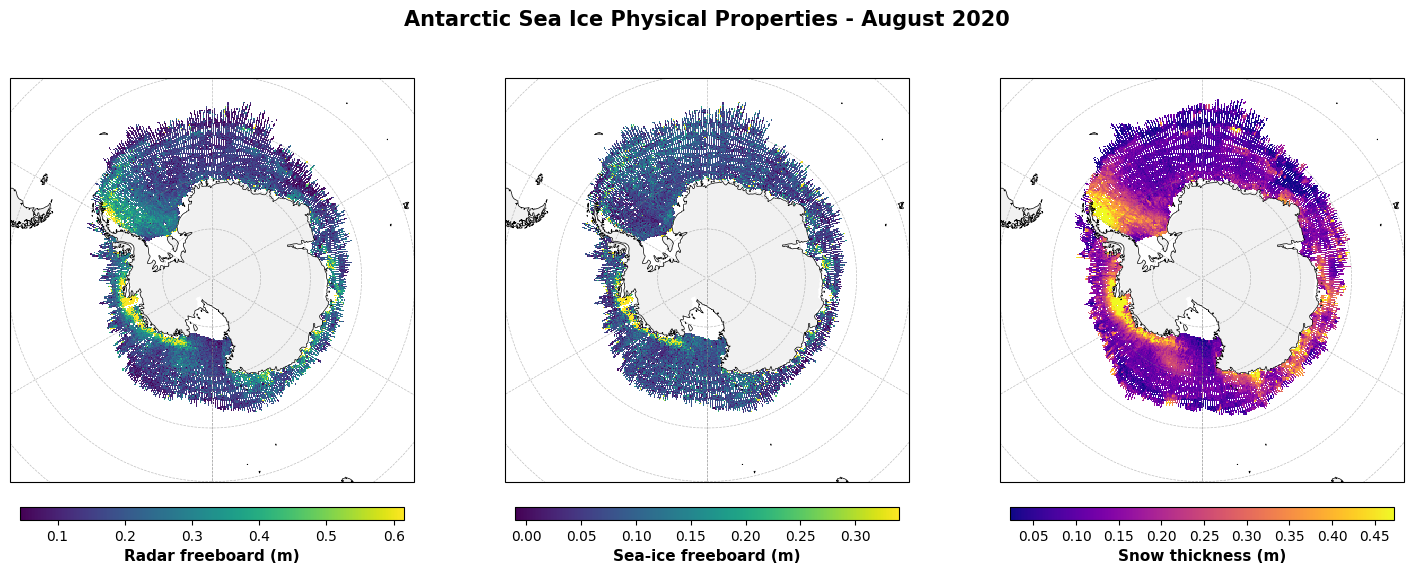

Summary Statistics (August 2020):
Radar Freeboard:   0.214 ± 0.147 m
Sea-ice Freeboard: 0.091 ± 0.100 m
Snow Thickness:    0.166 ± 0.110 m


In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import os

# Define the data directory and file path
data_dir = r"D:\phd\data\Fons_2023_cs2fwa"
filename = "CS2WFA_25km_202008.nc"
filepath = os.path.join(data_dir, filename)

# Load the NetCDF dataset
ds = xr.open_dataset(filepath)

# Extract variables for the first time step
lat = ds['lat'].values
lon = ds['lon'].values
ice_freeboard = ds['ice_freeboard'].isel(time=0).values
snow_freeboard = ds['snow_freeboard'].isel(time=0).values
snow_depth = ds['snow_depth'].isel(time=0).values

# Replace invalid values (e.g., NaN or fill values) with NaN for proper plotting
ice_freeboard = np.where(np.isfinite(ice_freeboard), ice_freeboard, np.nan)
snow_freeboard = np.where(np.isfinite(snow_freeboard), snow_freeboard, np.nan)
snow_depth = np.where(np.isfinite(snow_depth), snow_depth, np.nan)

# Set up the figure with three subplots
fig = plt.figure(figsize=(15, 6))

# Define common parameters
projection = ccrs.SouthPolarStereo()
extent = [-180, 180, -90, -50]  # Antarctic region
data_vars = [snow_freeboard, ice_freeboard, snow_depth]
cmaps = ['viridis', 'viridis', 'plasma']
cbar_labels = ['Radar freeboard (m)', 'Sea-ice freeboard (m)', 'Snow thickness (m)']

# Create subplots
for i, (data, cmap, cbar_label) in enumerate(zip(data_vars, cmaps, cbar_labels)):
    ax = fig.add_subplot(1, 3, i+1, projection=projection)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Add coastlines and gridlines
    ax.coastlines(resolution='50m', linewidth=0.5, color='black')
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='none', alpha=0.3)
    ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    
    # Plot data
    vmin = np.nanpercentile(data, 2)
    vmax = np.nanpercentile(data, 98)
    
    im = ax.pcolormesh(lon, lat, data, 
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       vmin=vmin,
                       vmax=vmax,
                       shading='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', 
                       pad=0.05, shrink=0.8, aspect=30)
    cbar.set_label(cbar_label, fontsize=11, weight='bold')
    cbar.ax.tick_params(labelsize=10)

# Add main title with more space above subplots
fig.suptitle('Antarctic Sea Ice Physical Properties - August 2020', 
             fontsize=15, weight='bold', y=0.98)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

# Close the dataset
ds.close()

# Print summary statistics
print("Summary Statistics (August 2020):")
print("=" * 60)
print(f"Radar Freeboard:   {np.nanmean(snow_freeboard):.3f} ± {np.nanstd(snow_freeboard):.3f} m")
print(f"Sea-ice Freeboard: {np.nanmean(ice_freeboard):.3f} ± {np.nanstd(ice_freeboard):.3f} m")
print(f"Snow Thickness:    {np.nanmean(snow_depth):.3f} ± {np.nanstd(snow_depth):.3f} m")

## Visualise 13-Month Time Series of Sea Ice Physical Properties

This cell creates a comprehensive publication-quality figure showing the spatial and temporal evolution of sea-ice freeboard, total freeboard, and snow thickness across the Antarctic region from August 2020 to August 2021.

Loading datasets and computing global statistics...
Creating plots...
Completed: Aug 2020
Completed: Sep 2020
Completed: Oct 2020
Completed: Nov 2020
Completed: Dec 2020
Completed: Jan 2021
Completed: Feb 2021
Completed: Mar 2021
Completed: Apr 2021
Completed: May 2021
Completed: Jun 2021
Completed: Jul 2021
Completed: Aug 2021

Figure saved to: D:\phd\data\Fons_2023_cs2fwa\Antarctic_SeaIce_TimeSeries_2020-2021.png


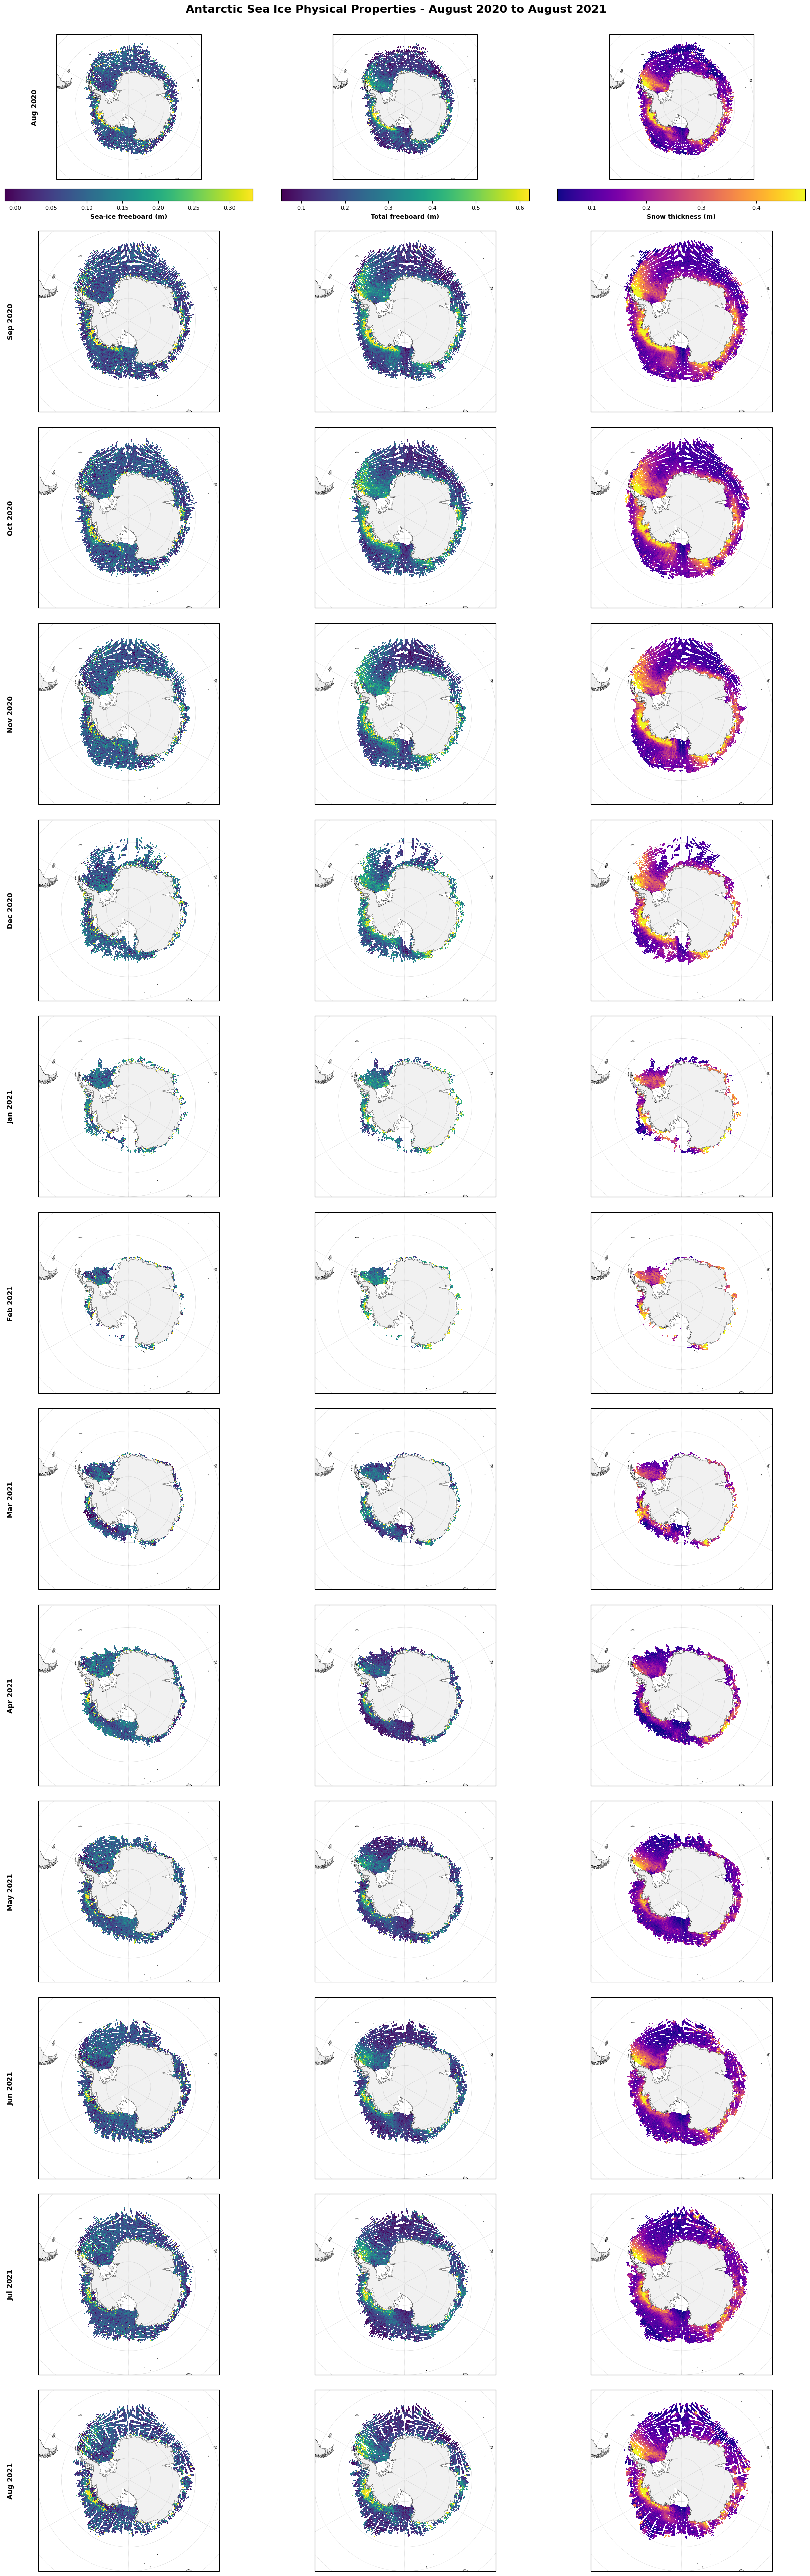


Analysis complete!


In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
from datetime import datetime

# Define the data directory
data_dir = r"D:\phd\data\Fons_2023_cs2fwa"

# Define time period (August 2020 to August 2021)
months = ['202008', '202009', '202010', '202011', '202012', 
          '202101', '202102', '202103', '202104', '202105', 
          '202106', '202107', '202108']

# Month names for labels
month_labels = ['Aug 2020', 'Sep 2020', 'Oct 2020', 'Nov 2020', 'Dec 2020',
                'Jan 2021', 'Feb 2021', 'Mar 2021', 'Apr 2021', 'May 2021',
                'Jun 2021', 'Jul 2021', 'Aug 2021']

# Set up the figure
fig = plt.figure(figsize=(18, 52))

# Define common parameters
projection = ccrs.SouthPolarStereo()
extent = [-180, 180, -90, -50]  # Antarctic region
cbar_labels = ['Sea-ice freeboard (m)', 'Total freeboard (m)', 'Snow thickness (m)']
cmaps = ['viridis', 'viridis', 'plasma']

# Load all datasets and compute global vmin/vmax for consistent color scaling
all_ice_freeboard = []
all_snow_freeboard = []
all_snow_depth = []

print("Loading datasets and computing global statistics...")
for month in months:
    filename = f"CS2WFA_25km_{month}.nc"
    filepath = os.path.join(data_dir, filename)
    
    if os.path.exists(filepath):
        ds = xr.open_dataset(filepath)
        all_ice_freeboard.append(ds['ice_freeboard'].isel(time=0).values)
        all_snow_freeboard.append(ds['snow_freeboard'].isel(time=0).values)
        all_snow_depth.append(ds['snow_depth'].isel(time=0).values)
        ds.close()
    else:
        print(f"Warning: {filename} not found")

# Compute global percentiles for consistent color scaling
ice_fb_vmin = np.nanpercentile(np.concatenate([arr.flatten() for arr in all_ice_freeboard]), 2)
ice_fb_vmax = np.nanpercentile(np.concatenate([arr.flatten() for arr in all_ice_freeboard]), 98)
snow_fb_vmin = np.nanpercentile(np.concatenate([arr.flatten() for arr in all_snow_freeboard]), 2)
snow_fb_vmax = np.nanpercentile(np.concatenate([arr.flatten() for arr in all_snow_freeboard]), 98)
snow_d_vmin = np.nanpercentile(np.concatenate([arr.flatten() for arr in all_snow_depth]), 2)
snow_d_vmax = np.nanpercentile(np.concatenate([arr.flatten() for arr in all_snow_depth]), 98)

vlims = [(ice_fb_vmin, ice_fb_vmax), (snow_fb_vmin, snow_fb_vmax), (snow_d_vmin, snow_d_vmax)]

print("Creating plots...")

# Create subplots for each month
for row, (month, month_label) in enumerate(zip(months, month_labels)):
    filename = f"CS2WFA_25km_{month}.nc"
    filepath = os.path.join(data_dir, filename)
    
    if not os.path.exists(filepath):
        continue
    
    # Load the NetCDF dataset
    ds = xr.open_dataset(filepath)
    
    # Extract variables
    lat = ds['lat'].values
    lon = ds['lon'].values
    ice_freeboard = ds['ice_freeboard'].isel(time=0).values
    snow_freeboard = ds['snow_freeboard'].isel(time=0).values
    snow_depth = ds['snow_depth'].isel(time=0).values
    
    # Replace invalid values with NaN
    ice_freeboard = np.where(np.isfinite(ice_freeboard), ice_freeboard, np.nan)
    snow_freeboard = np.where(np.isfinite(snow_freeboard), snow_freeboard, np.nan)
    snow_depth = np.where(np.isfinite(snow_depth), snow_depth, np.nan)
    
    data_vars = [ice_freeboard, snow_freeboard, snow_depth]
    
    # Create three columns for this month
    for col, (data, cmap, cbar_label, vlim) in enumerate(zip(data_vars, cmaps, cbar_labels, vlims)):
        ax = fig.add_subplot(13, 3, row*3 + col + 1, projection=projection)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        
        # Add coastlines and gridlines
        ax.coastlines(resolution='50m', linewidth=0.3, color='black')
        ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='none', alpha=0.3)
        ax.gridlines(draw_labels=False, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
        
        # Plot data with consistent color scaling
        im = ax.pcolormesh(lon, lat, data, 
                          transform=ccrs.PlateCarree(),
                          cmap=cmap,
                          vmin=vlim[0],
                          vmax=vlim[1],
                          shading='auto')
        
        # Add colorbar only for the first row
        if row == 0:
            cbar = plt.colorbar(im, ax=ax, orientation='horizontal', 
                              pad=0.05, shrink=0.8, aspect=20)
            cbar.set_label(cbar_label, fontsize=9, weight='bold')
            cbar.ax.tick_params(labelsize=8)
        
        # Add month label on the left side
        if col == 0:
            ax.text(-0.15, 0.5, month_label, transform=ax.transAxes,
                   fontsize=10, weight='bold', rotation=90, 
                   verticalalignment='center', horizontalalignment='center')
    
    ds.close()
    print(f"Completed: {month_label}")

# Add main title
fig.suptitle('Antarctic Sea Ice Physical Properties - August 2020 to August 2021', 
             fontsize=16, weight='bold', y=0.995)

# Adjust layout
plt.tight_layout(rect=[0.02, 0, 1, 0.993])

# Save the figure
output_file = os.path.join(data_dir, 'Antarctic_SeaIce_TimeSeries_2020-2021.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to: {output_file}")

plt.show()

print("\nAnalysis complete!")

## Analyse Regional Time Series of Sea Ice Physical Properties

This cell computes and visualizes the temporal evolution of sea-ice freeboard, total freeboard, and snow thickness across six Antarctic sectors from August 2020 to August 2021. The sectors are: Western Weddell, Eastern Weddell, Indian, Pacific, Ross, and Amundsen-Bellingshausen.

Processing datasets for regional analysis...
Processed: 202008
Processed: 202009
Processed: 202010
Processed: 202011
Processed: 202012
Processed: 202101
Processed: 202102
Processed: 202103
Processed: 202104
Processed: 202105
Processed: 202106
Processed: 202107
Processed: 202108

Figure saved to: D:\phd\data\Fons_2023_cs2fwa\Antarctic_Regional_TimeSeries_2020-2021.png


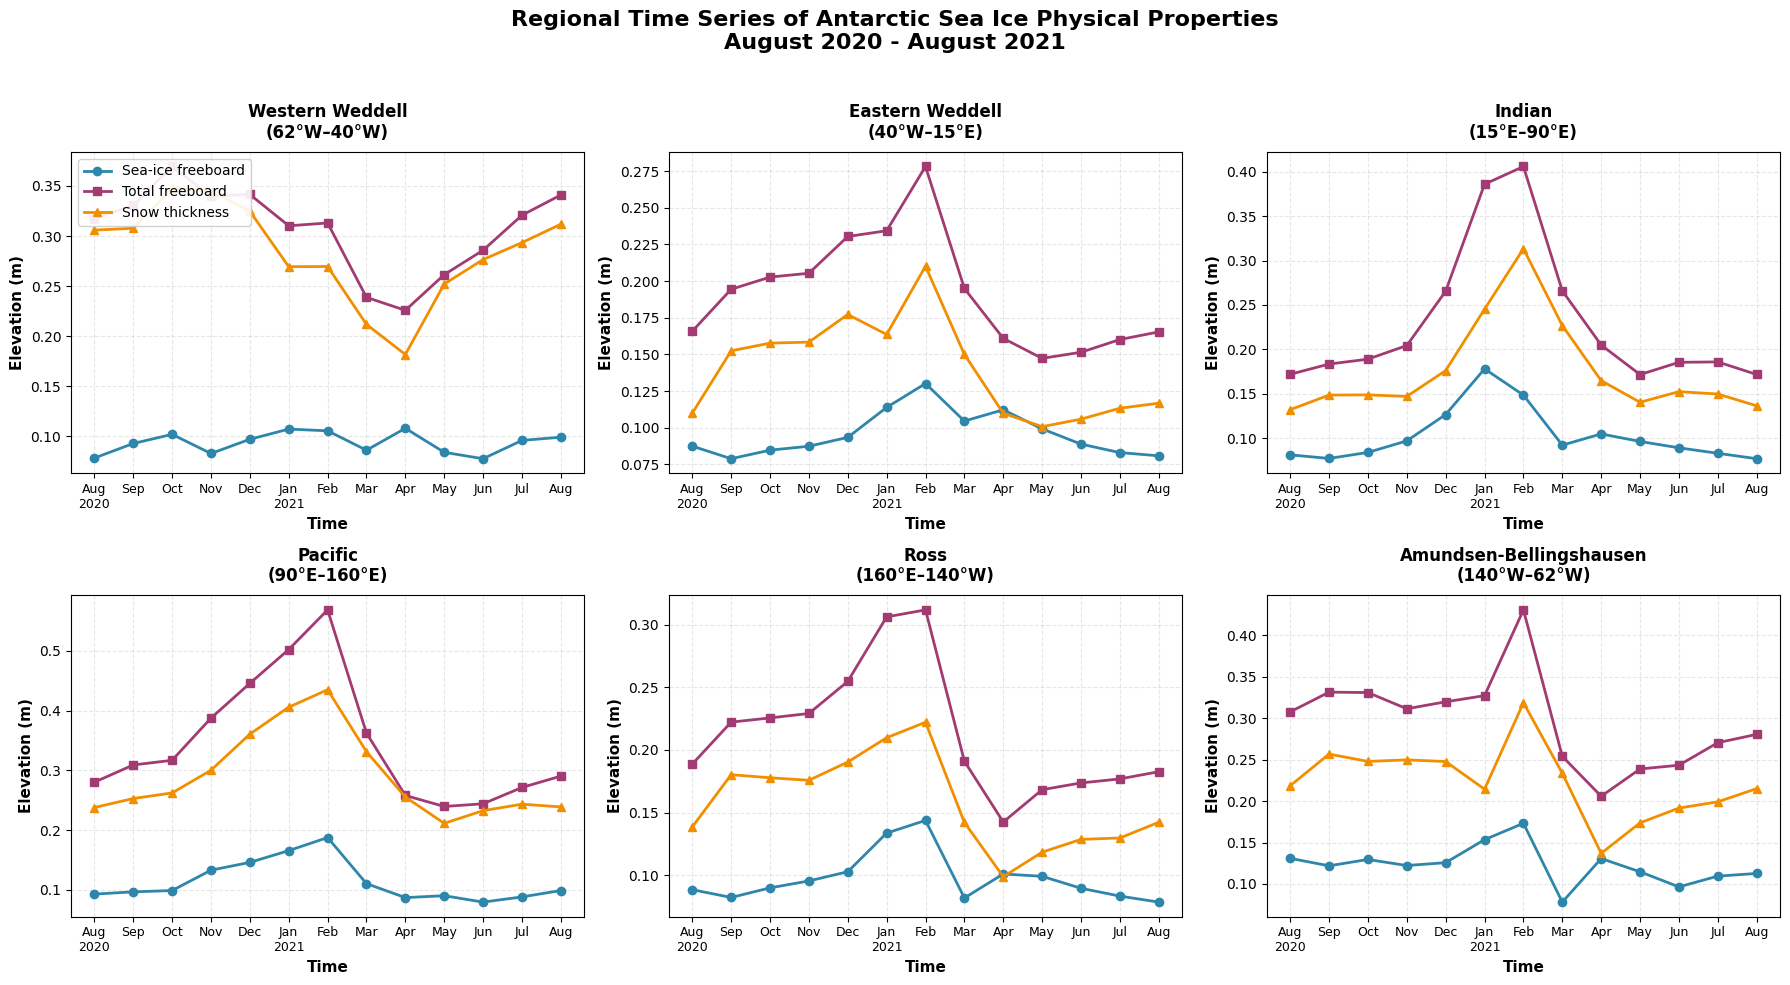


Regional Mean Values (August 2020 - August 2021)

Western Weddell (62°W–40°W):
  Sea-ice freeboard: 0.093 ± 0.010 m
  Total freeboard:   0.307 ± 0.041 m
  Snow thickness:    0.284 ± 0.047 m

Eastern Weddell (40°W–15°E):
  Sea-ice freeboard: 0.096 ± 0.015 m
  Total freeboard:   0.192 ± 0.037 m
  Snow thickness:    0.140 ± 0.032 m

Indian (15°E–90°E):
  Sea-ice freeboard: 0.103 ± 0.029 m
  Total freeboard:   0.230 ± 0.077 m
  Snow thickness:    0.175 ± 0.052 m

Pacific (90°E–160°E):
  Sea-ice freeboard: 0.114 ± 0.033 m
  Total freeboard:   0.344 ± 0.100 m
  Snow thickness:    0.290 ± 0.069 m

Ross (160°E–140°W):
  Sea-ice freeboard: 0.098 ± 0.019 m
  Total freeboard:   0.213 ± 0.050 m
  Snow thickness:    0.158 ± 0.036 m

Amundsen-Bellingshausen (140°W–62°W):
  Sea-ice freeboard: 0.123 ± 0.023 m
  Total freeboard:   0.296 ± 0.055 m
  Snow thickness:    0.223 ± 0.043 m

Analysis complete!


In [10]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Define the data directory
data_dir = r"D:\phd\data\Fons_2023_cs2fwa"

# Define time period (August 2020 to August 2021)
months = ['202008', '202009', '202010', '202011', '202012', 
          '202101', '202102', '202103', '202104', '202105', 
          '202106', '202107', '202108']

# Month names for x-axis
month_labels = ['Aug\n2020', 'Sep', 'Oct', 'Nov', 'Dec',
                'Jan\n2021', 'Feb', 'Mar', 'Apr', 'May',
                'Jun', 'Jul', 'Aug']

# Define six Antarctic sectors (longitude ranges)
# Convert all to 0-360 range for consistent handling
sectors = {
    'Western Weddell': (298, 320),      # -62°W to -40°W = 298°E to 320°E
    'Eastern Weddell': (320, 15),       # -40°W to 15°E = 320°E to 15°E (crosses 0°)
    'Indian': (15, 90),                 # 15°E to 90°E
    'Pacific': (90, 160),               # 90°E to 160°E
    'Ross': (160, 220),                 # 160°E to -140°W = 160°E to 220°E
    'Amundsen-Bellingshausen': (220, 298)  # -140°W to -62°W = 220°E to 298°E
}

# Initialize data storage for each sector
sector_data = {sector: {'ice_freeboard': [], 'snow_freeboard': [], 'snow_depth': []} 
               for sector in sectors.keys()}

print("Processing datasets for regional analysis...")

# Load and process each monthly dataset
for month in months:
    filename = f"CS2WFA_25km_{month}.nc"
    filepath = os.path.join(data_dir, filename)
    
    if not os.path.exists(filepath):
        print(f"Warning: {filename} not found")
        for sector in sectors.keys():
            sector_data[sector]['ice_freeboard'].append(np.nan)
            sector_data[sector]['snow_freeboard'].append(np.nan)
            sector_data[sector]['snow_depth'].append(np.nan)
        continue
    
    # Load dataset
    ds = xr.open_dataset(filepath)
    lat = ds['lat'].values
    lon = ds['lon'].values
    ice_freeboard = ds['ice_freeboard'].isel(time=0).values
    snow_freeboard = ds['snow_freeboard'].isel(time=0).values
    snow_depth = ds['snow_depth'].isel(time=0).values
    
    # Convert longitude from -180:180 to 0:360 for easier sector handling
    lon_360 = np.where(lon < 0, lon + 360, lon)
    
    # Process each sector
    for sector_name, (lon_min, lon_max) in sectors.items():
        # Create mask for this sector
        if lon_min < lon_max:
            # Normal case (doesn't cross 0° meridian)
            mask = (lon_360 >= lon_min) & (lon_360 <= lon_max)
        else:
            # Crosses 0° meridian (Eastern Weddell: 320° to 15°)
            mask = (lon_360 >= lon_min) | (lon_360 <= lon_max)
        
        # Apply mask and compute mean for each variable
        ice_fb_mean = np.nanmean(ice_freeboard[mask])
        snow_fb_mean = np.nanmean(snow_freeboard[mask])
        snow_d_mean = np.nanmean(snow_depth[mask])
        
        sector_data[sector_name]['ice_freeboard'].append(ice_fb_mean)
        sector_data[sector_name]['snow_freeboard'].append(snow_fb_mean)
        sector_data[sector_name]['snow_depth'].append(snow_d_mean)
    
    ds.close()
    print(f"Processed: {month}")

# Create figure with 6 subplots (2 rows x 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Sector display names with original longitude ranges
sector_labels = {
    'Western Weddell': '62°W–40°W',
    'Eastern Weddell': '40°W–15°E',
    'Indian': '15°E–90°E',
    'Pacific': '90°E–160°E',
    'Ross': '160°E–140°W',
    'Amundsen-Bellingshausen': '140°W–62°W'
}

# Plot data for each sector
for idx, (sector_name, data) in enumerate(sector_data.items()):
    ax = axes[idx]
    
    # Plot three variables
    x = np.arange(len(months))
    ax.plot(x, data['ice_freeboard'], 'o-', linewidth=2, markersize=6, 
            label='Sea-ice freeboard', color='#2E86AB')
    ax.plot(x, data['snow_freeboard'], 's-', linewidth=2, markersize=6, 
            label='Total freeboard', color='#A23B72')
    ax.plot(x, data['snow_depth'], '^-', linewidth=2, markersize=6, 
            label='Snow thickness', color='#F18F01')
    
    # Set labels and title
    ax.set_xlabel('Time', fontsize=11, weight='bold')
    ax.set_ylabel('Elevation (m)', fontsize=11, weight='bold')
    ax.set_title(f'{sector_name}\n({sector_labels[sector_name]})', 
                fontsize=12, weight='bold', pad=10)
    
    # Set x-axis ticks
    ax.set_xticks(x)
    ax.set_xticklabels(month_labels, fontsize=9)
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add legend only to first subplot
    if idx == 0:
        ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    
    # Format y-axis
    ax.tick_params(axis='y', labelsize=10)

# Add main title
fig.suptitle('Regional Time Series of Antarctic Sea Ice Physical Properties\nAugust 2020 - August 2021', 
             fontsize=16, weight='bold', y=0.98)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save figure
output_file = os.path.join(data_dir, 'Antarctic_Regional_TimeSeries_2020-2021.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to: {output_file}")

plt.show()

# Print summary statistics for each sector
print("\n" + "=" * 80)
print("Regional Mean Values (August 2020 - August 2021)")
print("=" * 80)
for sector_name, data in sector_data.items():
    print(f"\n{sector_name} ({sector_labels[sector_name]}):")
    print(f"  Sea-ice freeboard: {np.nanmean(data['ice_freeboard']):.3f} ± {np.nanstd(data['ice_freeboard']):.3f} m")
    print(f"  Total freeboard:   {np.nanmean(data['snow_freeboard']):.3f} ± {np.nanstd(data['snow_freeboard']):.3f} m")
    print(f"  Snow thickness:    {np.nanmean(data['snow_depth']):.3f} ± {np.nanstd(data['snow_depth']):.3f} m")

print("\nAnalysis complete!")

## Systematic Statistical Analysis of Regional Sea Ice Physical Properties

This cell conducts comprehensive statistical analysis of sea-ice freeboard, total freeboard, and snow thickness across six Antarctic sectors, including mean, standard deviation, coefficient of variation, trends, seasonal patterns, and inter-sectoral comparisons. Results are visualized in a publication-quality figure with statistical summary tables.

COMPREHENSIVE STATISTICAL ANALYSIS OF ANTARCTIC SEA ICE PHYSICAL PROPERTIES

Processing datasets...

Data processing complete. Conducting statistical analysis...

1. DESCRIPTIVE STATISTICS

Descriptive Statistics Summary:
                 Sector          Variable     Mean   Median  Std Dev      Min      Max    Range    CV (%)      Q25      Q75      IQR
        Western Weddell Sea-ice freeboard 0.093416 0.095745 0.010407 0.077463 0.107867 0.030404 11.140840 0.083846 0.101798 0.017952
        Western Weddell   Total freeboard 0.307343 0.317293 0.041170 0.225741 0.369463 0.143722 13.395390 0.285790 0.339966 0.054175
        Western Weddell    Snow thickness 0.284367 0.293395 0.046856 0.181593 0.347548 0.165956 16.477373 0.269352 0.311784 0.042433
        Eastern Weddell Sea-ice freeboard 0.095681 0.088765 0.014827 0.078812 0.130113 0.051301 15.496462 0.084647 0.104496 0.019850
        Eastern Weddell   Total freeboard 0.191635 0.194417 0.037238 0.147282 0.278173 0.130891 19.431679 0.16091

c:\Users\xliu38\OneDrive - University of Tasmania\PhD_manuscripts\manuscript2\scripts\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)
C:\Users\xliu38\AppData\Local\Temp\ipykernel_25500\939123477.py:351: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_box, labels=labels_for_box, patch_artist=True,
C:\Users\xliu38\AppData\Local\Temp\ipykernel_25500\939123477.py:351: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_box, labels=labels_for_box, patch_artist=True,
C:\Users\xliu38\AppData\Local\Temp\ipykernel_25500\939123477.py:351


Visualization saved to:
C:\Users\xliu38\OneDrive - University of Tasmania\PhD_manuscripts\manuscript2\figures\Antarctic_Statistical_Analysis_Visualization_2020-2021.png


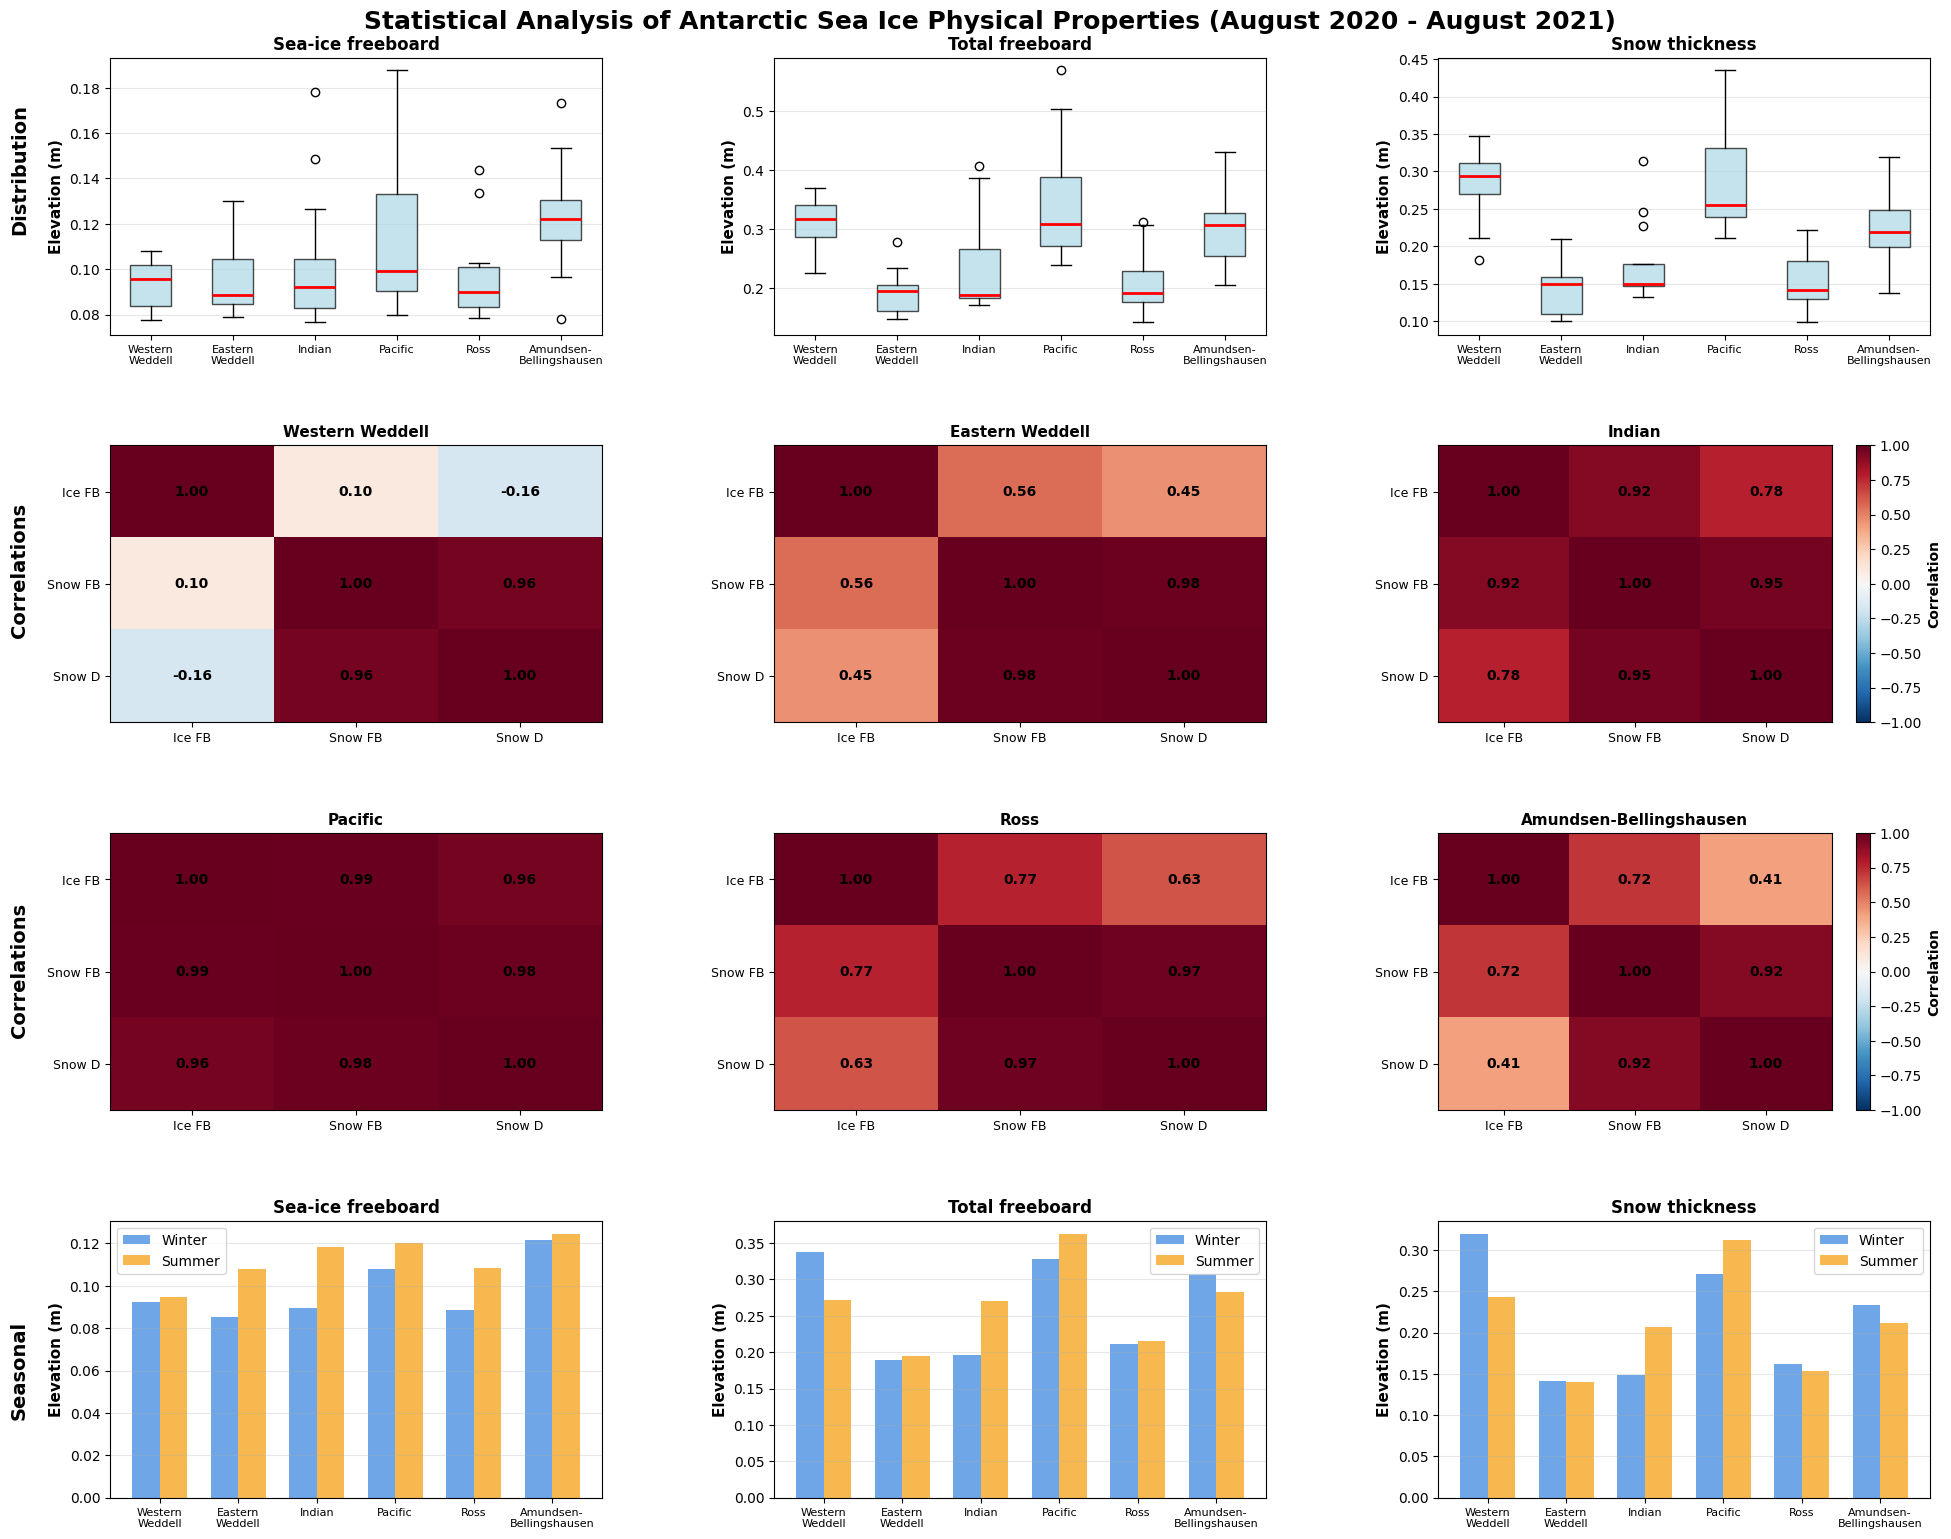


ANALYSIS COMPLETE!

All outputs saved to: C:\Users\xliu38\OneDrive - University of Tasmania\PhD_manuscripts\manuscript2\figures


In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import pearsonr, spearmanr, normaltest
import seaborn as sns
import os
from datetime import datetime

# Define directories
data_dir = r"D:\phd\data\Fons_2023_cs2fwa"
output_dir = r"C:\Users\xliu38\OneDrive - University of Tasmania\PhD_manuscripts\manuscript2\figures"
os.makedirs(output_dir, exist_ok=True)

# Define time period
months = ['202008', '202009', '202010', '202011', '202012', 
          '202101', '202102', '202103', '202104', '202105', 
          '202106', '202107', '202108']

# Define sectors
sectors = {
    'Western Weddell': (298, 320),
    'Eastern Weddell': (320, 15),
    'Indian': (15, 90),
    'Pacific': (90, 160),
    'Ross': (160, 220),
    'Amundsen-Bellingshausen': (220, 298)
}

sector_labels = {
    'Western Weddell': '62°W–40°W',
    'Eastern Weddell': '40°W–15°E',
    'Indian': '15°E–90°E',
    'Pacific': '90°E–160°E',
    'Ross': '160°E–140°W',
    'Amundsen-Bellingshausen': '140°W–62°W'
}

variable_names = {
    'ice_freeboard': 'Sea-ice freeboard',
    'snow_freeboard': 'Total freeboard',
    'snow_depth': 'Snow thickness'
}

print("="*90)
print("COMPREHENSIVE STATISTICAL ANALYSIS OF ANTARCTIC SEA ICE PHYSICAL PROPERTIES")
print("="*90)
print("\nProcessing datasets...\n")

# Initialize data storage
sector_data = {sector: {'ice_freeboard': [], 'snow_freeboard': [], 'snow_depth': []} 
               for sector in sectors.keys()}

# Load and process data
for month in months:
    filename = f"CS2WFA_25km_{month}.nc"
    filepath = os.path.join(data_dir, filename)
    
    if not os.path.exists(filepath):
        continue
    
    ds = xr.open_dataset(filepath)
    lat = ds['lat'].values
    lon = ds['lon'].values
    ice_freeboard = ds['ice_freeboard'].isel(time=0).values
    snow_freeboard = ds['snow_freeboard'].isel(time=0).values
    snow_depth = ds['snow_depth'].isel(time=0).values
    
    lon_360 = np.where(lon < 0, lon + 360, lon)
    
    for sector_name, (lon_min, lon_max) in sectors.items():
        if lon_min < lon_max:
            mask = (lon_360 >= lon_min) & (lon_360 <= lon_max)
        else:
            mask = (lon_360 >= lon_min) | (lon_360 <= lon_max)
        
        sector_data[sector_name]['ice_freeboard'].append(np.nanmean(ice_freeboard[mask]))
        sector_data[sector_name]['snow_freeboard'].append(np.nanmean(snow_freeboard[mask]))
        sector_data[sector_name]['snow_depth'].append(np.nanmean(snow_depth[mask]))
    
    ds.close()

print("Data processing complete. Conducting statistical analysis...\n")

# ============================================================================
# 1. DESCRIPTIVE STATISTICS
# ============================================================================
print("="*90)
print("1. DESCRIPTIVE STATISTICS")
print("="*90)

descriptive_stats = []
for sector_name in sectors.keys():
    for var_name in ['ice_freeboard', 'snow_freeboard', 'snow_depth']:
        data = np.array(sector_data[sector_name][var_name])
        
        descriptive_stats.append({
            'Sector': sector_name,
            'Variable': variable_names[var_name],
            'Mean': np.nanmean(data),
            'Median': np.nanmedian(data),
            'Std Dev': np.nanstd(data),
            'Min': np.nanmin(data),
            'Max': np.nanmax(data),
            'Range': np.nanmax(data) - np.nanmin(data),
            'CV (%)': (np.nanstd(data) / np.nanmean(data) * 100) if np.nanmean(data) != 0 else np.nan,
            'Q25': np.nanpercentile(data, 25),
            'Q75': np.nanpercentile(data, 75),
            'IQR': np.nanpercentile(data, 75) - np.nanpercentile(data, 25)
        })

df_descriptive = pd.DataFrame(descriptive_stats)
print("\nDescriptive Statistics Summary:")
print(df_descriptive.to_string(index=False))

# ============================================================================
# 2. DISTRIBUTION ANALYSIS & NORMALITY TESTS
# ============================================================================
print("\n" + "="*90)
print("2. DISTRIBUTION ANALYSIS & NORMALITY TESTS")
print("="*90)

normality_results = []
for sector_name in sectors.keys():
    for var_name in ['ice_freeboard', 'snow_freeboard', 'snow_depth']:
        data = np.array(sector_data[sector_name][var_name])
        valid_data = data[~np.isnan(data)]
        
        if len(valid_data) > 3:
            stat, p_value = normaltest(valid_data)
            skewness = stats.skew(valid_data)
            kurtosis = stats.kurtosis(valid_data)
            
            normality_results.append({
                'Sector': sector_name,
                'Variable': variable_names[var_name],
                'Normality Test Statistic': stat,
                'P-value': p_value,
                'Normal?': 'Yes' if p_value > 0.05 else 'No',
                'Skewness': skewness,
                'Kurtosis': kurtosis
            })

df_normality = pd.DataFrame(normality_results)
print("\nNormality Test Results:")
print(df_normality.to_string(index=False))

# ============================================================================
# 3. TEMPORAL TREND ANALYSIS
# ============================================================================
print("\n" + "="*90)
print("3. TEMPORAL TREND ANALYSIS")
print("="*90)

trend_results = []
x = np.arange(len(months))

for sector_name in sectors.keys():
    for var_name in ['ice_freeboard', 'snow_freeboard', 'snow_depth']:
        data = np.array(sector_data[sector_name][var_name])
        valid_mask = ~np.isnan(data)
        
        if np.sum(valid_mask) > 2:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x[valid_mask], data[valid_mask])
            
            trend_results.append({
                'Sector': sector_name,
                'Variable': variable_names[var_name],
                'Slope (m/month)': slope,
                'Total Change (m)': slope * len(months),
                'R²': r_value**2,
                'P-value': p_value,
                'Significant?': 'Yes' if p_value < 0.05 else 'No',
                'Trend Direction': 'Increasing' if slope > 0 else 'Decreasing'
            })

df_trends = pd.DataFrame(trend_results)
print("\nTemporal Trend Analysis:")
print(df_trends.to_string(index=False))

# ============================================================================
# 4. INTER-VARIABLE CORRELATION ANALYSIS
# ============================================================================
print("\n" + "="*90)
print("4. INTER-VARIABLE CORRELATION ANALYSIS (Within Each Sector)")
print("="*90)

correlation_results = []
for sector_name in sectors.keys():
    ice_fb = np.array(sector_data[sector_name]['ice_freeboard'])
    snow_fb = np.array(sector_data[sector_name]['snow_freeboard'])
    snow_d = np.array(sector_data[sector_name]['snow_depth'])
    
    # Remove NaN values for correlation
    valid_mask = ~(np.isnan(ice_fb) | np.isnan(snow_fb) | np.isnan(snow_d))
    
    if np.sum(valid_mask) > 2:
        # Ice FB vs Snow FB
        r1, p1 = pearsonr(ice_fb[valid_mask], snow_fb[valid_mask])
        # Ice FB vs Snow Depth
        r2, p2 = pearsonr(ice_fb[valid_mask], snow_d[valid_mask])
        # Snow FB vs Snow Depth
        r3, p3 = pearsonr(snow_fb[valid_mask], snow_d[valid_mask])
        
        correlation_results.append({
            'Sector': sector_name,
            'Ice FB vs Snow FB (r)': r1,
            'Ice FB vs Snow FB (p)': p1,
            'Ice FB vs Snow D (r)': r2,
            'Ice FB vs Snow D (p)': p2,
            'Snow FB vs Snow D (r)': r3,
            'Snow FB vs Snow D (p)': p3
        })

df_correlation = pd.DataFrame(correlation_results)
print("\nInter-variable Correlation Analysis:")
print(df_correlation.to_string(index=False))

# ============================================================================
# 5. INTER-SECTORAL COMPARISON (ANOVA)
# ============================================================================
print("\n" + "="*90)
print("5. INTER-SECTORAL COMPARISON (ONE-WAY ANOVA)")
print("="*90)

anova_results = []
for var_name in ['ice_freeboard', 'snow_freeboard', 'snow_depth']:
    sector_groups = [np.array(sector_data[sector][var_name]) for sector in sectors.keys()]
    
    # Remove NaN values from each group
    sector_groups_clean = [group[~np.isnan(group)] for group in sector_groups]
    
    if all(len(group) > 0 for group in sector_groups_clean):
        f_stat, p_value = stats.f_oneway(*sector_groups_clean)
        
        anova_results.append({
            'Variable': variable_names[var_name],
            'F-statistic': f_stat,
            'P-value': p_value,
            'Significant Difference?': 'Yes' if p_value < 0.05 else 'No'
        })

df_anova = pd.DataFrame(anova_results)
print("\nOne-Way ANOVA Results:")
print(df_anova.to_string(index=False))

# ============================================================================
# 6. SEASONAL ANALYSIS
# ============================================================================
print("\n" + "="*90)
print("6. SEASONAL ANALYSIS (Winter vs Summer)")
print("="*90)

seasonal_results = []
winter_months = [0, 1, 2, 3, 4, 11, 12]  # Aug-Dec 2020, Aug 2021
summer_months = [5, 6, 7, 8, 9, 10]       # Jan-Jun 2021

for sector_name in sectors.keys():
    for var_name in ['ice_freeboard', 'snow_freeboard', 'snow_depth']:
        data = np.array(sector_data[sector_name][var_name])
        
        winter_data = [data[i] for i in winter_months if i < len(data)]
        summer_data = [data[i] for i in summer_months if i < len(data)]
        
        winter_mean = np.nanmean(winter_data)
        summer_mean = np.nanmean(summer_data)
        seasonal_amplitude = winter_mean - summer_mean
        percent_change = (seasonal_amplitude / winter_mean * 100) if winter_mean != 0 else np.nan
        
        # T-test for seasonal difference
        winter_clean = np.array(winter_data)[~np.isnan(winter_data)]
        summer_clean = np.array(summer_data)[~np.isnan(summer_data)]
        
        if len(winter_clean) > 1 and len(summer_clean) > 1:
            t_stat, p_value = stats.ttest_ind(winter_clean, summer_clean)
        else:
            t_stat, p_value = np.nan, np.nan
        
        seasonal_results.append({
            'Sector': sector_name,
            'Variable': variable_names[var_name],
            'Winter Mean (m)': winter_mean,
            'Summer Mean (m)': summer_mean,
            'Amplitude (m)': seasonal_amplitude,
            'Change (%)': percent_change,
            'T-statistic': t_stat,
            'P-value': p_value,
            'Significant?': 'Yes' if p_value < 0.05 else 'No'
        })

df_seasonal = pd.DataFrame(seasonal_results)
print("\nSeasonal Analysis:")
print(df_seasonal.to_string(index=False))

# ============================================================================
# SAVE ALL STATISTICAL TABLES
# ============================================================================
print("\n" + "="*90)
print("SAVING STATISTICAL RESULTS")
print("="*90)

# Try to save as Excel, fall back to CSV if openpyxl is not available
try:
    import openpyxl
    excel_file = os.path.join(output_dir, 'Antarctic_Statistical_Analysis_2020-2021.xlsx')
    with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
        df_descriptive.to_excel(writer, sheet_name='Descriptive_Statistics', index=False)
        df_normality.to_excel(writer, sheet_name='Normality_Tests', index=False)
        df_trends.to_excel(writer, sheet_name='Temporal_Trends', index=False)
        df_correlation.to_excel(writer, sheet_name='Correlations', index=False)
        df_anova.to_excel(writer, sheet_name='ANOVA', index=False)
        df_seasonal.to_excel(writer, sheet_name='Seasonal_Analysis', index=False)
    print(f"\nStatistical tables saved to Excel file:\n{excel_file}")
except ImportError:
    print("\nWarning: openpyxl not installed. Saving as CSV files instead.")
    print("To install openpyxl, run: pip install openpyxl")

# Save as individual CSV files (always)
df_descriptive.to_csv(os.path.join(output_dir, 'Antarctic_Descriptive_Statistics.csv'), index=False)
df_normality.to_csv(os.path.join(output_dir, 'Antarctic_Normality_Tests.csv'), index=False)
df_trends.to_csv(os.path.join(output_dir, 'Antarctic_Temporal_Trends.csv'), index=False)
df_correlation.to_csv(os.path.join(output_dir, 'Antarctic_Correlations.csv'), index=False)
df_anova.to_csv(os.path.join(output_dir, 'Antarctic_ANOVA.csv'), index=False)
df_seasonal.to_csv(os.path.join(output_dir, 'Antarctic_Seasonal_Analysis.csv'), index=False)

print(f"\nCSV files saved to: {output_dir}")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n" + "="*90)
print("CREATING STATISTICAL VISUALIZATIONS")
print("="*90)

# Create comprehensive figure
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.35, top=0.95, bottom=0.05, left=0.06, right=0.97)

# 1. Box plots by sector (3 subplots for 3 variables)
for idx, var_name in enumerate(['ice_freeboard', 'snow_freeboard', 'snow_depth']):
    ax = fig.add_subplot(gs[0, idx])
    
    data_for_box = []
    labels_for_box = []
    for sector_name in sectors.keys():
        data = np.array(sector_data[sector_name][var_name])
        data_for_box.append(data[~np.isnan(data)])
        labels_for_box.append(sector_name.replace(' ', '\n').replace('-', '-\n'))
    
    bp = ax.boxplot(data_for_box, labels=labels_for_box, patch_artist=True,
                    medianprops=dict(color='red', linewidth=2),
                    boxprops=dict(facecolor='lightblue', alpha=0.7))
    
    ax.set_ylabel('Elevation (m)', fontsize=11, weight='bold')
    ax.set_title(f'{variable_names[var_name]}', fontsize=12, weight='bold')
    ax.tick_params(axis='x', labelsize=8, rotation=0)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, alpha=0.3, axis='y')

# 2. Correlation heatmaps (3 subplots for 3 sectors)
for idx, sector_name in enumerate(list(sectors.keys())[:3]):
    ax = fig.add_subplot(gs[1, idx])
    
    ice_fb = np.array(sector_data[sector_name]['ice_freeboard'])
    snow_fb = np.array(sector_data[sector_name]['snow_freeboard'])
    snow_d = np.array(sector_data[sector_name]['snow_depth'])
    
    valid_mask = ~(np.isnan(ice_fb) | np.isnan(snow_fb) | np.isnan(snow_d))
    
    if np.sum(valid_mask) > 2:
        corr_data = np.column_stack([ice_fb[valid_mask], snow_fb[valid_mask], snow_d[valid_mask]])
        corr_matrix = np.corrcoef(corr_data.T)
        
        im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
        ax.set_xticks([0, 1, 2])
        ax.set_yticks([0, 1, 2])
        ax.set_xticklabels(['Ice FB', 'Snow FB', 'Snow D'], fontsize=9)
        ax.set_yticklabels(['Ice FB', 'Snow FB', 'Snow D'], fontsize=9)
        ax.set_title(f'{sector_name}', fontsize=11, weight='bold')
        
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                             ha="center", va="center", color="black", fontsize=10, weight='bold')
        
        if idx == 2:
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Correlation', fontsize=10, weight='bold')

# 3. Correlation heatmaps (3 subplots for remaining 3 sectors)
for idx, sector_name in enumerate(list(sectors.keys())[3:]):
    ax = fig.add_subplot(gs[2, idx])
    
    ice_fb = np.array(sector_data[sector_name]['ice_freeboard'])
    snow_fb = np.array(sector_data[sector_name]['snow_freeboard'])
    snow_d = np.array(sector_data[sector_name]['snow_depth'])
    
    valid_mask = ~(np.isnan(ice_fb) | np.isnan(snow_fb) | np.isnan(snow_d))
    
    if np.sum(valid_mask) > 2:
        corr_data = np.column_stack([ice_fb[valid_mask], snow_fb[valid_mask], snow_d[valid_mask]])
        corr_matrix = np.corrcoef(corr_data.T)
        
        im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
        ax.set_xticks([0, 1, 2])
        ax.set_yticks([0, 1, 2])
        ax.set_xticklabels(['Ice FB', 'Snow FB', 'Snow D'], fontsize=9)
        ax.set_yticklabels(['Ice FB', 'Snow FB', 'Snow D'], fontsize=9)
        ax.set_title(f'{sector_name}', fontsize=11, weight='bold')
        
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                             ha="center", va="center", color="black", fontsize=10, weight='bold')
        
        if idx == 2:
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Correlation', fontsize=10, weight='bold')

# 4. Seasonal bar charts (3 subplots)
for idx, var_name in enumerate(['ice_freeboard', 'snow_freeboard', 'snow_depth']):
    ax = fig.add_subplot(gs[3, idx])
    
    winter_means = []
    summer_means = []
    sector_names_short = []
    
    for sector_name in sectors.keys():
        data = np.array(sector_data[sector_name][var_name])
        winter_data = [data[i] for i in winter_months if i < len(data)]
        summer_data = [data[i] for i in summer_months if i < len(data)]
        
        winter_means.append(np.nanmean(winter_data))
        summer_means.append(np.nanmean(summer_data))
        sector_names_short.append(sector_name.replace(' ', '\n').replace('-', '-\n'))
    
    x = np.arange(len(sectors))
    width = 0.35
    
    ax.bar(x - width/2, winter_means, width, label='Winter', color='#4A90E2', alpha=0.8)
    ax.bar(x + width/2, summer_means, width, label='Summer', color='#F5A623', alpha=0.8)
    
    ax.set_ylabel('Elevation (m)', fontsize=11, weight='bold')
    ax.set_title(f'{variable_names[var_name]}', fontsize=12, weight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(sector_names_short, fontsize=8)
    ax.tick_params(axis='y', labelsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

# Add main title
fig.suptitle('Statistical Analysis of Antarctic Sea Ice Physical Properties (August 2020 - August 2021)', 
             fontsize=18, weight='bold', y=0.98)

# Add row labels
fig.text(0.01, 0.88, 'Distribution', fontsize=14, weight='bold', rotation=90, va='center')
fig.text(0.01, 0.63, 'Correlations', fontsize=14, weight='bold', rotation=90, va='center')
fig.text(0.01, 0.38, 'Correlations', fontsize=14, weight='bold', rotation=90, va='center')
fig.text(0.01, 0.13, 'Seasonal', fontsize=14, weight='bold', rotation=90, va='center')

# Save figure
output_file = os.path.join(output_dir, 'Antarctic_Statistical_Analysis_Visualization_2020-2021.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nVisualization saved to:\n{output_file}")

plt.show()

print("\n" + "="*90)
print("ANALYSIS COMPLETE!")
print("="*90)
print(f"\nAll outputs saved to: {output_dir}")

## Save Complete Gridded Data to NetCDF

This cell consolidates all monthly gridded data for sea-ice freeboard, total freeboard, and snow thickness from August 2020 to August 2021 into a single NetCDF file, and then verifies the saved data by inspecting the file structure.

In [16]:
import xarray as xr
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Define directories
data_dir = r"D:\phd\data\Fons_2023_cs2fwa"
output_file = os.path.join(data_dir, 'Antarctic_SeaIce_Complete_2020-2021.nc')

print("="*90)
print("CONSOLIDATING MONTHLY GRIDDED DATA TO SINGLE NETCDF FILE")
print("="*90)

# Define time period
months = ['202008', '202009', '202010', '202011', '202012', 
          '202101', '202102', '202103', '202104', '202105', 
          '202106', '202107', '202108']

# Create proper datetime objects for each month
time_coords = pd.to_datetime([f"{m[:4]}-{m[4:]}-15" for m in months])

print("\nLoading monthly datasets...\n")

# Load all monthly datasets
datasets = []
for i, month in enumerate(months):
    filename = f"CS2WFA_25km_{month}.nc"
    filepath = os.path.join(data_dir, filename)
    
    if os.path.exists(filepath):
        ds = xr.open_dataset(filepath)
        
        # Replace the time coordinate with proper datetime
        ds = ds.assign_coords(time=pd.DatetimeIndex([time_coords[i]]))
        
        datasets.append(ds)
        print(f"✓ Loaded: {filename}")
    else:
        print(f"✗ Warning: {filename} not found")

if not datasets:
    print("\nError: No datasets found!")
else:
    print(f"\nSuccessfully loaded {len(datasets)} datasets")
    
    # Concatenate all datasets along the time dimension
    print("\nConcatenating datasets along time dimension...")
    ds_combined = xr.concat(datasets, dim='time')
    
    # Update global attributes
    ds_combined.attrs.update({
        'title': 'Antarctic Sea Ice Physical Properties - Complete Time Series',
        'institution': 'University of Tasmania',
        'source': 'Consolidated from CS2WFA 25km monthly products (Fons et al., 2023)',
        'references': 'Fons, S. W., et al. (2023)',
        'history': f'Consolidated on {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}',
        'Conventions': 'CF-1.8',
        'time_coverage_start': '2020-08-01',
        'time_coverage_end': '2021-08-31',
        'geospatial_lat_min': -90.0,
        'geospatial_lat_max': -50.0,
        'geospatial_lon_min': -180.0,
        'geospatial_lon_max': 180.0,
        'description': 'Complete gridded time series of sea-ice freeboard, total freeboard, and snow thickness for the Antarctic region',
        'processing_level': 'Level 4 - Consolidated monthly gridded products',
        'spatial_resolution': '25 km',
        'number_of_months': len(datasets),
        'variables': 'ice_freeboard, snow_freeboard, snow_depth, lat, lon'
    })
    
    # Add more descriptive variable attributes
    if 'ice_freeboard' in ds_combined.variables:
        ds_combined['ice_freeboard'].attrs['long_name'] = 'Sea-ice freeboard'
        ds_combined['ice_freeboard'].attrs['standard_name'] = 'sea_ice_freeboard'
    
    if 'snow_freeboard' in ds_combined.variables:
        ds_combined['snow_freeboard'].attrs['long_name'] = 'Total freeboard (radar freeboard)'
        ds_combined['snow_freeboard'].attrs['standard_name'] = 'radar_freeboard'
    
    if 'snow_depth' in ds_combined.variables:
        ds_combined['snow_depth'].attrs['long_name'] = 'Snow thickness'
        ds_combined['snow_depth'].attrs['standard_name'] = 'snow_depth'
    
    # Update time coordinate attributes
    ds_combined['time'].attrs.update({
        'long_name': 'Time (middle of month)',
        'standard_name': 'time',
        'axis': 'T'
    })
    
    # Save to NetCDF
    print(f"\nSaving consolidated dataset to: {output_file}")
    print("This may take a few moments...")
    
    # Use compression and proper encoding for all variables including time
    encoding = {
        'time': {'units': 'days since 1970-01-01', 'calendar': 'standard', 'dtype': 'float64'}
    }
    
    # Add compression for data variables
    for var in ds_combined.data_vars:
        encoding[var] = {'zlib': True, 'complevel': 4, 'dtype': 'float32'}
    
    # Add encoding for coordinate variables if needed
    if 'lat' in ds_combined.coords and 'lat' not in ds_combined.dims:
        encoding['lat'] = {'zlib': True, 'complevel': 4, 'dtype': 'float32'}
    if 'lon' in ds_combined.coords and 'lon' not in ds_combined.dims:
        encoding['lon'] = {'zlib': True, 'complevel': 4, 'dtype': 'float32'}
    
    ds_combined.to_netcdf(output_file, encoding=encoding, format='NETCDF4')
    
    print("✓ NetCDF file saved successfully!")
    
    # Close all datasets
    for ds in datasets:
        ds.close()
    ds_combined.close()
    
    # ============================================================================
    # VERIFICATION: INSPECT THE SAVED NETCDF FILE
    # ============================================================================
    print("\n" + "="*90)
    print("VERIFYING SAVED NETCDF FILE")
    print("="*90)
    
    # Load the saved NetCDF file
    ds_verify = xr.open_dataset(output_file)
    
    print("\n" + "="*90)
    print("Dataset Overview:")
    print("="*90)
    print(ds_verify)
    
    print("\n" + "="*90)
    print("Dimensions:")
    print("="*90)
    for dim, size in ds_verify.dims.items():
        print(f"  {dim}: {size}")
    
    print("\n" + "="*90)
    print("Coordinates:")
    print("="*90)
    for coord in ds_verify.coords:
        print(f"\n  {coord}:")
        print(f"    Shape: {ds_verify.coords[coord].shape}")
        print(f"    Dtype: {ds_verify.coords[coord].dtype}")
        if hasattr(ds_verify.coords[coord], 'long_name'):
            print(f"    Long name: {ds_verify.coords[coord].long_name}")
        if hasattr(ds_verify.coords[coord], 'units'):
            print(f"    Units: {ds_verify.coords[coord].units}")
        
        # Display coordinate ranges
        if coord == 'time':
            print(f"    Range: {ds_verify.coords[coord].values[0]} to {ds_verify.coords[coord].values[-1]}")
            print(f"    Number of time steps: {len(ds_verify.coords[coord])}")
        elif coord in ['lat', 'lon', 'x', 'y']:
            print(f"    Min: {float(ds_verify.coords[coord].min()):.2f}")
            print(f"    Max: {float(ds_verify.coords[coord].max()):.2f}")
    
    print("\n" + "="*90)
    print("Data Variables:")
    print("="*90)
    for var in ds_verify.data_vars:
        print(f"\n  {var}:")
        print(f"    Shape: {ds_verify[var].shape}")
        print(f"    Dtype: {ds_verify[var].dtype}")
        if hasattr(ds_verify[var], 'long_name'):
            print(f"    Long name: {ds_verify[var].long_name}")
        if hasattr(ds_verify[var], 'units'):
            print(f"    Units: {ds_verify[var].units}")
        if hasattr(ds_verify[var], 'description'):
            print(f"    Description: {ds_verify[var].description}")
        
        # Display statistics for main variables
        if var in ['ice_freeboard', 'snow_freeboard', 'snow_depth']:
            data = ds_verify[var].values
            print(f"    Global Statistics:")
            print(f"      Mean: {np.nanmean(data):.4f} m")
            print(f"      Std Dev: {np.nanstd(data):.4f} m")
            print(f"      Min: {np.nanmin(data):.4f} m")
            print(f"      Max: {np.nanmax(data):.4f} m")
            print(f"      Valid points: {np.sum(~np.isnan(data)):,} / {data.size:,} ({np.sum(~np.isnan(data))/data.size*100:.1f}%)")
    
    print("\n" + "="*90)
    print("Global Attributes:")
    print("="*90)
    for attr, value in ds_verify.attrs.items():
        print(f"  {attr}: {value}")
    
    # Display temporal statistics
    print("\n" + "="*90)
    print("Temporal Statistics (Mean values per month):")
    print("="*90)
    print("\nSea-ice Freeboard (m):")
    for i, time_val in enumerate(ds_verify.time.values):
        mean_val = float(ds_verify['ice_freeboard'].isel(time=i).mean())
        print(f"  {pd.Timestamp(time_val).strftime('%Y-%m-%d')}: {mean_val:.4f}")
    
    print("\nTotal Freeboard (m):")
    for i, time_val in enumerate(ds_verify.time.values):
        mean_val = float(ds_verify['snow_freeboard'].isel(time=i).mean())
        print(f"  {pd.Timestamp(time_val).strftime('%Y-%m-%d')}: {mean_val:.4f}")
    
    print("\nSnow Thickness (m):")
    for i, time_val in enumerate(ds_verify.time.values):
        mean_val = float(ds_verify['snow_depth'].isel(time=i).mean())
        print(f"  {pd.Timestamp(time_val).strftime('%Y-%m-%d')}: {mean_val:.4f}")
    
    # Display file size information
    file_size_mb = os.path.getsize(output_file) / (1024 * 1024)
    print("\n" + "="*90)
    print("File Information:")
    print("="*90)
    print(f"  File path: {output_file}")
    print(f"  File size: {file_size_mb:.2f} MB")
    print(f"  Format: NetCDF4 (with compression)")
    
    # Close the verification dataset
    ds_verify.close()
    
    print("\n" + "="*90)
    print("VERIFICATION COMPLETE!")
    print("="*90)
    print(f"\nComplete gridded dataset successfully saved and verified!")
    print(f"The file contains {len(months)} months of data with full spatial coverage.")

CONSOLIDATING MONTHLY GRIDDED DATA TO SINGLE NETCDF FILE

Loading monthly datasets...

✓ Loaded: CS2WFA_25km_202008.nc
✓ Loaded: CS2WFA_25km_202009.nc
✓ Loaded: CS2WFA_25km_202010.nc
✓ Loaded: CS2WFA_25km_202011.nc
✓ Loaded: CS2WFA_25km_202012.nc
✓ Loaded: CS2WFA_25km_202101.nc
✓ Loaded: CS2WFA_25km_202102.nc
✓ Loaded: CS2WFA_25km_202103.nc
✓ Loaded: CS2WFA_25km_202104.nc
✓ Loaded: CS2WFA_25km_202105.nc
✓ Loaded: CS2WFA_25km_202106.nc
✓ Loaded: CS2WFA_25km_202107.nc
✓ Loaded: CS2WFA_25km_202108.nc

Successfully loaded 13 datasets

Concatenating datasets along time dimension...

Saving consolidated dataset to: D:\phd\data\Fons_2023_cs2fwa\Antarctic_SeaIce_Complete_2020-2021.nc
This may take a few moments...
✓ NetCDF file saved successfully!

VERIFYING SAVED NETCDF FILE

Dataset Overview:
<xarray.Dataset> Size: 33MB
Dimensions:                (time: 13, y: 332, x: 316)
Coordinates:
  * time                   (time) datetime64[ns] 104B 2020-08-15 ... 2021-08-15
Dimensions without coordina

C:\Users\xliu38\AppData\Local\Temp\ipykernel_25500\1969882863.py:138: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for dim, size in ds_verify.dims.items():
